In [1]:
import torch
import numpy as np
import torch.linalg as linalg
import math
import matplotlib.pyplot as plt
from src.loss_functions.number_token_loss import NumberTokenLoss
from torch.nn.functional import softmax

In [2]:
def calculate_1d_wasserstein_dist(X, Y):
    """
    Compute the 1D Wasserstein distance (Earth Mover's Distance) between two distributions X and Y.
    """
    
    # Ensure inputs are 1D distributions
    if X.ndim != 1 or Y.ndim != 1:
        raise ValueError("Expecting 1D inputs for X and Y!")
    
    # Ensure X and Y have the same shape
    if X.shape != Y.shape:
        raise ValueError("Expecting equal shapes for X and Y!")
    
    # Normalize the distributions to ensure they sum to 1 (optional depending on your case)
    X = X / X.sum()
    Y = Y / Y.sum()
    
    # Compute the cumulative distributions (CDFs)
    cdf_X = torch.cumsum(X, dim=0)
    cdf_Y = torch.cumsum(Y, dim=0)
    
    # Compute the Wasserstein distance as the L1 distance between the two CDFs
    wasserstein_dist = torch.sum(torch.abs(cdf_X - cdf_Y))
    
    return wasserstein_dist

In [3]:
# Set Latex font
import matplotlib as mpl
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [4]:
# Plot 1

real_number = 4
gt = torch.Tensor([0,0,0,0,1,0,0,0,0,0])

labels = torch.full((10,), 4)
all_numbers = torch.arange(0, 10)
logits = torch.full((10,10), 0.01)

for i in range(10):
    # Value on the diagonal sets "spikiness" of the distribution
    logits[i][i] = 5

logits_softmaxed = softmax(logits, dim=1)

loss_ce = torch.nn.CrossEntropyLoss(reduction='none')
loss_mse = torch.nn.MSELoss(reduction='none')


In [5]:
y_hat = (logits_softmaxed*all_numbers[None,:]).sum(dim=1)

loss_values_ce = loss_ce(logits,labels)
loss_values_mse = loss_mse(y_hat, labels)
loss_values_wass = [calculate_1d_wasserstein_dist(tensor, gt).item() for tensor in logits_softmaxed]



In [6]:
loss_values_wass

[3.9038069248199463,
 2.967935562133789,
 2.032064437866211,
 1.0961933135986328,
 0.16032208502292633,
 1.0961933135986328,
 2.032064437866211,
 2.967935562133789,
 3.9038069248199463,
 4.8396782875061035]

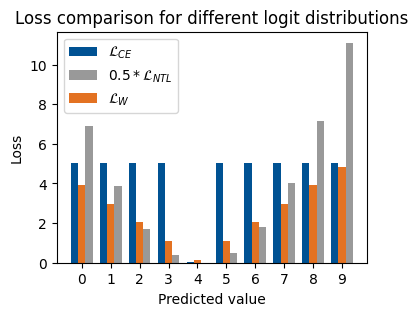

In [7]:
# Bar width
bar_width = 0.25

# X positions for the bars
r1 = all_numbers - bar_width
r2 = all_numbers + bar_width
r3 = all_numbers

# Create the plot
plt.figure(figsize=(4, 3))

# Plot bars
plt.bar(r1, loss_values_ce, width=bar_width, color='#005293', label='$\mathcal{L}_{CE}$')
plt.bar(r2, 0.5*loss_values_mse, width=bar_width, color='#999999', label='$0.5*\mathcal{L}_{NTL}$')
#plt.bar(r3, 0.5*loss_values_mse+loss_values_ce, width=bar_width, color='#e37222', label='$0.5*\mathcal{L}_{NTL} + \mathcal{L}_{CE}$')
plt.bar(r3, loss_values_wass, width=bar_width, color='#e37222', label='$\mathcal{L}_{W}$')

# Add labels
plt.xlabel('Predicted value')
plt.ylabel('Loss')
plt.title('Loss comparison for different logit distributions')
plt.xticks(all_numbers)  # Set x-ticks to be the integer values
plt.legend()

plt.savefig('loss_comparison.pdf',bbox_inches='tight')
# Show the plot
plt.show()

#add summation

In [8]:
# Second Plot

real_number = 4
gt = torch.Tensor([0,1,0])
labels = torch.full((3,),1 )
label_values = torch.full((3,), 4)
all_numbers = torch.Tensor([3,4,5])
logits = torch.zeros((3,3))


logits = torch.Tensor([[0.2, 0.6, 0.2],
                        [0.333, 0.333, 0.333],
                        [0.45, 0.1, 0.45]])

logits_softmaxed = softmax(logits, dim=1)

In [9]:
y_hat = (logits_softmaxed*all_numbers[None,:]).sum(dim=1)

loss_values_ce = loss_ce(logits,labels)
loss_values_mse = loss_mse(y_hat, label_values)
loss_values_wass = [calculate_1d_wasserstein_dist(tensor, gt).item() for tensor in logits_softmaxed]

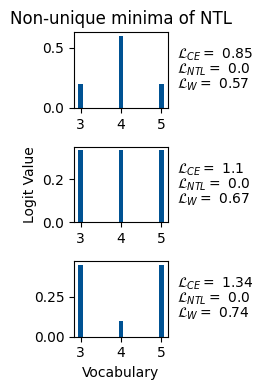

In [10]:
# Bar width
bar_width = 0.12

fig, axes = plt.subplots(3, 1, figsize=(8, 4))

# Loop over the subplots and plot 2 sets per subplot
for i, ax in enumerate(axes):
    r1 = all_numbers
    ax.bar(r1, logits[i], width=bar_width, color='#005293')
    if i ==0:
        ax.title.set_text('Non-unique minima of NTL')

    if i ==1:
        ax.set_ylabel('Logit Value')
    if i ==2:
        ax.set_xlabel('Vocabulary')
    # Set title and labels
    #ax.set_ylabel('Logit Value')
    ax.set_xticks(all_numbers)
    ax.text(1.1, 0.65, "$\mathcal{L}_{CE} = $"+f" {round(loss_values_ce[i].item(),2)}", transform=ax.transAxes)
    ax.text(1.1, 0.45, "$\mathcal{L}_{NTL} = $"+f" {round(0.5*loss_values_mse[i].item(),2)}", transform=ax.transAxes)
    #ax.text(1.1, 0.25, "$\mathcal{L}_{CE}+0.5*\mathcal{L}_{NTL} = $"+f" {round(loss_values_ce[i].item()+0.5*loss_values_mse[i].item(),2)}", transform=ax.transAxes)
    ax.text(1.1, 0.25, "$\mathcal{L}_{W} = $"+f" {round(loss_values_wass[i],2)}", transform=ax.transAxes)

plt.tight_layout()
plt.subplots_adjust(right=0.2)

plt.savefig('loss_comparison_2.pdf',bbox_inches='tight')

# Adjust layout and show the plot
plt.show()

In [11]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy.ma as ma


In [35]:
def plot_heatmap(x, title, show_colorbar=False, disable_yaxis=False, size: int=15):
    """
    Plots a heatmap based on the provided x data.

    Parameters:
    - x (numpy.ma.MaskedArray): 2D masked array with values to plot.
    - title (str): Title of the heatmap.
    - show_colorbar (bool): 
        If True, displays a colorbar alongside the heatmap.
        If False, omits the colorbar.
        Defaults to False.

    Returns:
    - None
    """
    if not isinstance(x, ma.MaskedArray):
        raise TypeError("x must be a numpy.ma.MaskedArray.")
    if x.ndim != 2:
        raise ValueError("x must be a 2D array.")
    if x.shape[0] != x.shape[1]:
        raise ValueError("x must be a square (NxN) array.")

    grid_size = x.shape[0]

    cmap = LinearSegmentedColormap.from_list('GreenYellowRed', ['#006400', '#FFFF00', '#FF0000'])

    fig, ax = plt.subplots(figsize=(4,4))
    
    if show_colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)

    sns.heatmap(
        x,
        cmap=cmap,
        cbar=False,              
        square=True,
        xticklabels=False,
        yticklabels=False,
        linewidths=0,             
        mask=x.mask,     
        vmin=x.min(),
        vmax=x.max(),       
        ax=ax
    )
    ax.invert_yaxis()
    
    ticks = np.arange(0, 1 + 0.5, 0.5)
    tick_positions = (ticks * (grid_size - 1)).astype(int)
    tick_positions[-1] = grid_size - 1
    tick_labels = [f"{val:.1f}" for val in ticks]

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=25, size=size)
    ax.set_yticks(tick_positions)

    if disable_yaxis:
        ax.set_yticklabels([])
    else:
        ax.set_yticks(tick_positions)
        ax.set_yticklabels(tick_labels, size=size)
        ax.set_ylabel('Logit [5]', size=size)

    if show_colorbar:
        # Create a ScalarMappable for the colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=x.min(), vmax=x.max()))
        cbar = fig.colorbar(sm, cax=cax, orientation='vertical')

        cbar_ticks = np.linspace(x.min(), x.max(), 3)
        cbar.set_ticks(cbar_ticks)
        cbar.set_ticklabels([f"{val:.1f}" for val in cbar_ticks], size=size)

    ax.set_title(title, size=size)
    ax.set_xlabel('Logit [3]', size=size)
#     plt.show()
    
    plt.savefig(f"{title}.png", bbox_inches='tight', dpi=100)


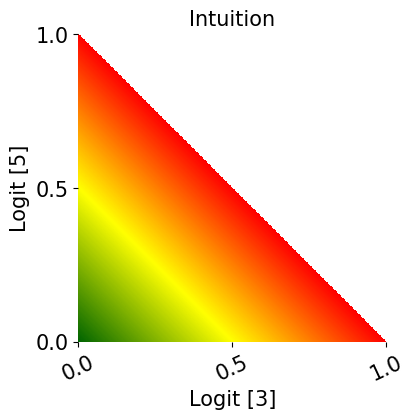

In [29]:


grid_size = 1000

three_token = np.linspace(0, 1, grid_size)
five_token = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(three_token, five_token)

sum_indices = X + Y
mask = sum_indices > 1
masked_sum = ma.masked_where(mask, sum_indices)
plot_title = 'Intuition'
plot_heatmap(masked_sum, plot_title)


In [30]:
grid_size = 1000

ce_spikiness = 5
three_token = np.linspace(0, 1, grid_size)
five_token = np.linspace(0, 1, grid_size)
mesh3, mesh5 = np.meshgrid(three_token, five_token)
mesh3 = mesh3.reshape(grid_size**2, -1)
mesh5 = mesh5.reshape(grid_size**2, -1)
mesh4 = 1 - (mesh3 + mesh5)

labels = torch.full((grid_size**2,),1 )
label_values = torch.full((grid_size**2,), 4)


logits = torch.Tensor(np.stack([mesh3, mesh4, mesh5], axis=-1)).squeeze()
logits_softmaxed = softmax(logits, dim=1)
y_hat = (logits*all_numbers[None,:]).sum(dim=1)
ce = loss_ce(logits*ce_spikiness, labels).squeeze().numpy().reshape(grid_size, grid_size)
mse = loss_mse(y_hat, label_values).squeeze().numpy().reshape(grid_size, grid_size)


In [31]:
wass = torch.stack([calculate_1d_wasserstein_dist(tensor, gt) for tensor in logits]).squeeze().numpy().reshape(grid_size, grid_size)


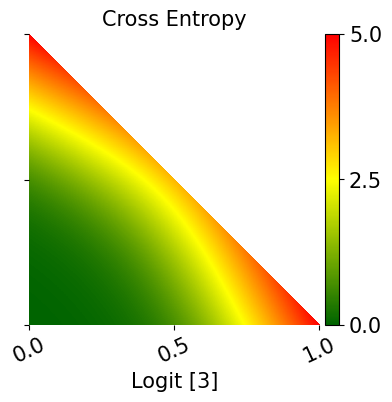

In [36]:

ce_masked = ma.masked_where((mesh4.reshape(grid_size, grid_size)<0), ce)
plot_title = 'Cross Entropy'
plot_heatmap(ce_masked, plot_title,show_colorbar=True, disable_yaxis=True)


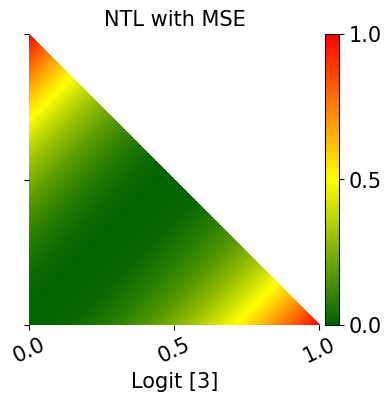

In [37]:

mse_masked = ma.masked_where(mesh4.reshape(grid_size, grid_size)<0, mse)
plot_title = 'NTL with MSE'
plot_heatmap(mse_masked, plot_title,show_colorbar=True, disable_yaxis=True)


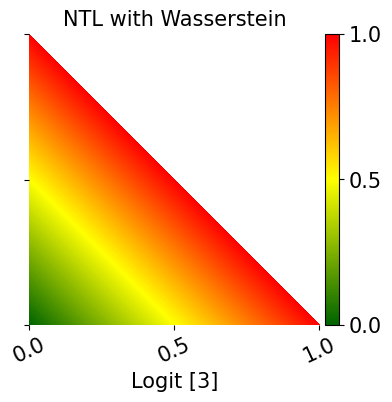

In [38]:

wass_masked = ma.masked_where(mesh4.reshape(grid_size, grid_size)<0, wass)
plot_title = 'NTL with Wasserstein'
plot_heatmap(wass_masked, plot_title,show_colorbar=True, disable_yaxis=True)


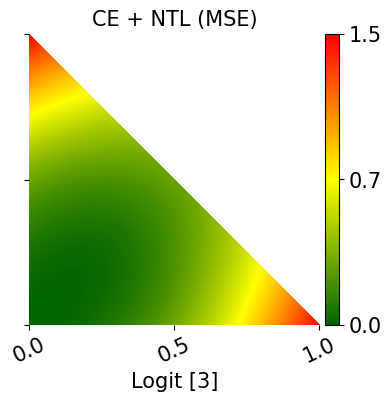

In [44]:
centl = ce/ce.max() + mse

centl_masked = ma.masked_where((mesh4.reshape(grid_size, grid_size)<0), centl)
plot_title = 'CE + NTL (MSE)'
plot_heatmap(centl_masked, plot_title,show_colorbar=True, disable_yaxis=True)
